## import

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import albumentations as A
import torch
import torch.nn.functional as F
import torchinfo
from albumentations.pytorch.transforms import ToTensorV2
from torch.utils.data import DataLoader
from torchlake.common.constants import VOC_CLASS_NAMES
from torchlake.common.utils.convert import img_tensor_to_np
from torchlake.common.utils.image import decode_segmap, load_image
from torchlake.common.utils.plot import plot_grids
from torchlake.common.utils.platform import get_file_size, get_num_workers
from torchlake.common.controller.trainer import ClassificationTrainer
from torchlake.common.controller.evaluator import ClassificationEvaluator
from torchlake.common.datasets.voc.constants import LABEL_COLORS
from torchlake.common.datasets.voc.segmentation import VOCSegmentation
from torchlake.semantic_segmentation.models.dilation import DilationNet, dilation_net_style_vgg
from tqdm import tqdm

d:\research\pytorch-implementations\gits\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# setting

In [2]:
artifacts_path = Path("../../artifacts/dilation-net")
artifacts_path.mkdir(exist_ok=True)

data_path = Path("../../data")

In [3]:
DEVICE = torch.device("cuda:0")

# data

In [4]:
BATCH_SIZE = 8
IMAGE_SIZE = 320
NUM_CLASS = len(VOC_CLASS_NAMES)

In [5]:
preprocess = A.Compose(
    [
        A.HorizontalFlip(),
        A.Resize(IMAGE_SIZE, IMAGE_SIZE),
        A.Normalize(0, 1), # in feature extractor
        ToTensorV2(),
    ]
)

test_preprocess = A.Compose(
    [
        A.Resize(IMAGE_SIZE, IMAGE_SIZE),
        A.Normalize(0, 1), # in feature extractor
        ToTensorV2(),
    ]
)

In [6]:
train_dataset = VOCSegmentation(
    data_path.as_posix(),
    year="2012",
    transform=preprocess,
)

test_dataset = VOCSegmentation(
    data_path.as_posix(),
    year="2007",
    transform=test_preprocess,
)

In [7]:
NUM_WORKERS = get_num_workers()

In [8]:
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    num_workers=NUM_WORKERS,
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
)

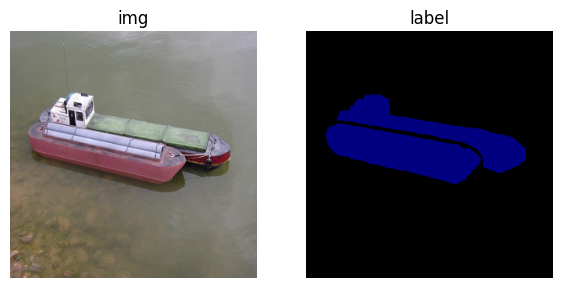

In [9]:
interest_pic = 102
img, label = train_dataset[interest_pic]

plot_grids(
    [
        img_tensor_to_np(img),
        decode_segmap(label, LABEL_COLORS),
    ],
    ["img", "label"],
    1,
    2,
    figsize=(7, 7),
)

# model

In [10]:
backbone = dilation_net_style_vgg("vgg16", trainable=True)
model = DilationNet(backbone, NUM_CLASS + 1, context_type=None).to(DEVICE)

In [11]:
torchinfo.summary(model)

Layer (type:depth-idx)                   Param #
DilationNet                              --
├─VGGFeatureExtractor: 1-1               --
│    └─Sequential: 2-1                   --
│    │    └─Conv2d: 3-1                  1,792
│    │    └─ReLU: 3-2                    --
│    │    └─Conv2d: 3-3                  36,928
│    │    └─ReLU: 3-4                    --
│    │    └─MaxPool2d: 3-5               --
│    │    └─Conv2d: 3-6                  73,856
│    │    └─ReLU: 3-7                    --
│    │    └─Conv2d: 3-8                  147,584
│    │    └─ReLU: 3-9                    --
│    │    └─MaxPool2d: 3-10              --
│    │    └─Conv2d: 3-11                 295,168
│    │    └─ReLU: 3-12                   --
│    │    └─Conv2d: 3-13                 590,080
│    │    └─ReLU: 3-14                   --
│    │    └─Conv2d: 3-15                 590,080
│    │    └─ReLU: 3-16                   --
│    │    └─MaxPool2d: 3-17              --
│    │    └─Conv2d: 3-18                

# train

## frontend

In [12]:
backbone = dilation_net_style_vgg("vgg16", trainable=True)
model = DilationNet(backbone, NUM_CLASS + 1, context_type=None).to(DEVICE)

In [13]:
EPOCHS = 10

In [14]:
trainer = ClassificationTrainer(EPOCHS, DEVICE)
trainer.recorder.increment_data_size(len(train_dataset))

In [15]:
criterion = trainer.get_criterion(NUM_CLASS)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [16]:
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, threshold=.05 ,threshold_mode ='rel')

In [17]:
training_loss = trainer.run(train_loader, model, optimizer, criterion, scheduler)

Enable AMP: False
Training...


100%|██████████| 364/364 [03:49<00:00,  1.59it/s]


------------------------------------
Epoch 1
------------------------------------
total: 1.1920e-01 (0.00%)


100%|██████████| 364/364 [03:04<00:00,  1.97it/s]


------------------------------------
Epoch 2
------------------------------------
total: 7.0627e-02 (-41.00%)


100%|██████████| 364/364 [03:04<00:00,  1.97it/s]


------------------------------------
Epoch 3
------------------------------------
total: 5.2631e-02 (-25.00%)


100%|██████████| 364/364 [03:04<00:00,  1.97it/s]


------------------------------------
Epoch 4
------------------------------------
total: 4.2585e-02 (-19.00%)


100%|██████████| 364/364 [03:04<00:00,  1.97it/s]


------------------------------------
Epoch 5
------------------------------------
total: 3.5836e-02 (-16.00%)


100%|██████████| 364/364 [03:40<00:00,  1.65it/s]


------------------------------------
Epoch 6
------------------------------------
total: 3.4119e-02 (-5.00%)


100%|██████████| 364/364 [04:44<00:00,  1.28it/s]


------------------------------------
Epoch 7
------------------------------------
total: 2.9472e-02 (-14.00%)


100%|██████████| 364/364 [04:43<00:00,  1.28it/s]


------------------------------------
Epoch 8
------------------------------------
total: 2.4903e-02 (-16.00%)


100%|██████████| 364/364 [04:44<00:00,  1.28it/s]


------------------------------------
Epoch 9
------------------------------------
total: 2.5379e-02 (2.00%)


100%|██████████| 364/364 [04:44<00:00,  1.28it/s]

------------------------------------
Epoch 10
------------------------------------
total: 2.7401e-02 (8.00%)


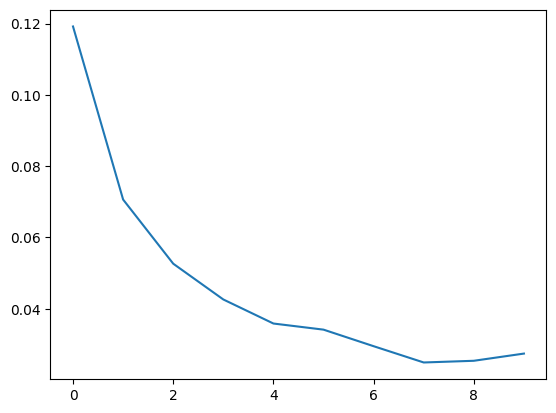

In [18]:
plt.plot(trainer.recorder.training_losses[0])

In [19]:
model_path = artifacts_path.joinpath('dilation8.frontend.pth')

In [20]:
torch.save(model.state_dict(), model_path)

In [21]:
get_file_size(model_path)

'512.53MiB'

## joint

In [22]:
backbone = dilation_net_style_vgg("vgg16", trainable=True)
joint_model = DilationNet(backbone, NUM_CLASS + 1, context_type="basic").to(DEVICE)

joint_model.load_state_dict(model.state_dict(), strict=False)

_IncompatibleKeys(missing_keys=['neck.0.blocks.0.0.weight', 'neck.0.blocks.0.0.bias', 'neck.0.blocks.1.0.weight', 'neck.0.blocks.1.0.bias', 'neck.0.blocks.2.0.weight', 'neck.0.blocks.2.0.bias', 'neck.0.blocks.3.0.weight', 'neck.0.blocks.3.0.bias', 'neck.0.blocks.4.0.weight', 'neck.0.blocks.4.0.bias', 'neck.0.blocks.5.0.weight', 'neck.0.blocks.5.0.bias', 'neck.0.blocks.6.0.weight', 'neck.0.blocks.6.0.bias', 'neck.0.blocks.7.0.weight', 'neck.0.blocks.7.0.bias', 'neck.0.blocks.8.0.weight', 'neck.0.blocks.8.0.bias'], unexpected_keys=[])

In [23]:
EPOCHS = 10

In [24]:
trainer = ClassificationTrainer(EPOCHS, DEVICE)
trainer.recorder.increment_data_size(len(train_dataset))

In [25]:
criterion = trainer.get_criterion(NUM_CLASS)
optimizer = torch.optim.Adam(joint_model.parameters(), lr=1e-4)

In [26]:
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, threshold=.05 ,threshold_mode ='rel')

In [27]:
training_loss = trainer.run(train_loader, joint_model, optimizer, criterion, scheduler)

Enable AMP: False
Training...


100%|██████████| 364/364 [04:42<00:00,  1.29it/s]


------------------------------------
Epoch 1
------------------------------------
total: 1.0029e-01 (0.00%)


100%|██████████| 364/364 [04:41<00:00,  1.29it/s]


------------------------------------
Epoch 2
------------------------------------
total: 4.3376e-02 (-57.00%)


100%|██████████| 364/364 [04:42<00:00,  1.29it/s]


------------------------------------
Epoch 3
------------------------------------
total: 2.6589e-02 (-39.00%)


100%|██████████| 364/364 [04:41<00:00,  1.29it/s]


------------------------------------
Epoch 4
------------------------------------
total: 2.2363e-02 (-16.00%)


100%|██████████| 364/364 [04:41<00:00,  1.29it/s]


------------------------------------
Epoch 5
------------------------------------
total: 1.8842e-02 (-16.00%)


100%|██████████| 364/364 [04:41<00:00,  1.29it/s]


------------------------------------
Epoch 6
------------------------------------
total: 1.6473e-02 (-13.00%)


100%|██████████| 364/364 [04:41<00:00,  1.29it/s]


------------------------------------
Epoch 7
------------------------------------
total: 1.5637e-02 (-5.00%)


100%|██████████| 364/364 [04:41<00:00,  1.29it/s]


------------------------------------
Epoch 8
------------------------------------
total: 1.8317e-02 (17.00%)


100%|██████████| 364/364 [04:40<00:00,  1.30it/s]


------------------------------------
Epoch 9
------------------------------------
total: 2.7487e-02 (50.00%)


100%|██████████| 364/364 [04:41<00:00,  1.29it/s]

------------------------------------
Epoch 10
------------------------------------
total: 2.0031e-02 (-27.00%)


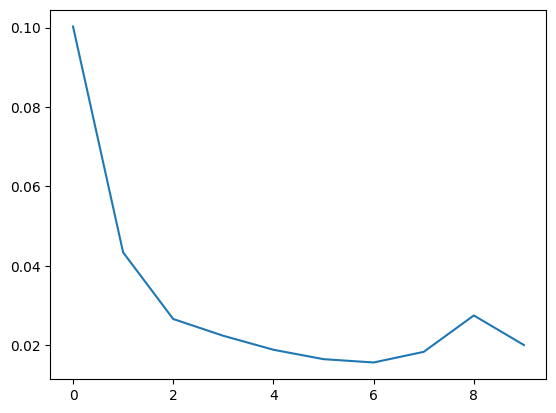

In [28]:
plt.plot(trainer.recorder.training_losses[0])

In [29]:
joint_model_path = artifacts_path.joinpath('dilation8.{context_type}.pth')

In [30]:
torch.save(joint_model.state_dict(), joint_model_path)

In [31]:
get_file_size(joint_model_path)

'512.66MiB'

# inference

In [32]:
joint_model.load_state_dict(torch.load(joint_model_path), strict=False)

<All keys matched successfully>

### mIOU

#### frontend

In [33]:
from torchmetrics.classification import jaccard

metric = jaccard.MulticlassJaccardIndex(NUM_CLASS + 1, average=None)

In [34]:
evaluator = ClassificationEvaluator(NUM_CLASS+1, DEVICE)

In [35]:
metric = evaluator.run(test_loader, model, metric)

100%|██████████| 79/79 [00:59<00:00,  1.33it/s]


In [36]:
for class_name, value in zip(VOC_CLASS_NAMES, metric.compute()[1:].mul(100).round().tolist()):
    print("{:<15}: {:<5}".format(class_name, value / 100))

print("----------------------")
print("{:<15}: {:<5}".format("total", metric.compute()[1:].mean().mul(100).round().item()/100))

aeroplane      : 0.81 
bicycle        : 0.26 
bird           : 0.85 
boat           : 0.77 
bottle         : 0.8  
bus            : 0.9  
car            : 0.83 
cat            : 0.87 
chair          : 0.46 
cow            : 0.78 
diningtable    : 0.77 
dog            : 0.79 
horse          : 0.72 
motorbike      : 0.77 
person         : 0.81 
pottedplant    : 0.48 
sheep          : 0.8  
sofa           : 0.69 
train          : 0.88 
tvmonitor      : 0.8  
----------------------
total          : 0.74 


(<Figure size 640x480 with 1 Axes>, <Axes: ylabel='MulticlassJaccardIndex'>)

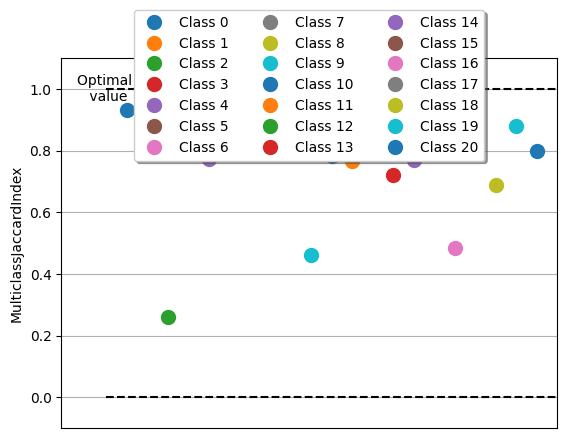

In [37]:
metric.plot()

#### joint

In [38]:
from torchmetrics.classification import jaccard

metric = jaccard.MulticlassJaccardIndex(NUM_CLASS + 1, average=None)

In [39]:
evaluator = ClassificationEvaluator(NUM_CLASS+1, DEVICE)

In [40]:
metric = evaluator.run(test_loader, joint_model, metric)

100%|██████████| 79/79 [00:31<00:00,  2.49it/s]


In [41]:
for class_name, value in zip(VOC_CLASS_NAMES, metric.compute()[1:].mul(100).round().tolist()):
    print("{:<15}: {:<5}".format(class_name, value / 100))

print("----------------------")
print("{:<15}: {:<5}".format("total", metric.compute()[1:].mean().mul(100).round().item()/100))

aeroplane      : 0.85 
bicycle        : 0.54 
bird           : 0.9  
boat           : 0.83 
bottle         : 0.85 
bus            : 0.92 
car            : 0.86 
cat            : 0.91 
chair          : 0.6  
cow            : 0.85 
diningtable    : 0.86 
dog            : 0.86 
horse          : 0.78 
motorbike      : 0.82 
person         : 0.85 
pottedplant    : 0.6  
sheep          : 0.87 
sofa           : 0.83 
train          : 0.91 
tvmonitor      : 0.82 
----------------------
total          : 0.82 


(<Figure size 640x480 with 1 Axes>, <Axes: ylabel='MulticlassJaccardIndex'>)

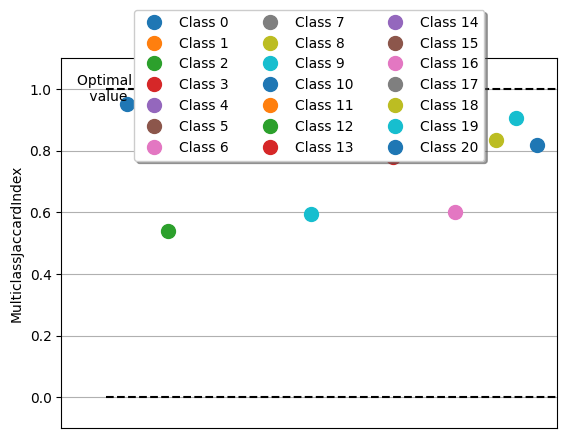

In [42]:
metric.plot()

### for image in dataset

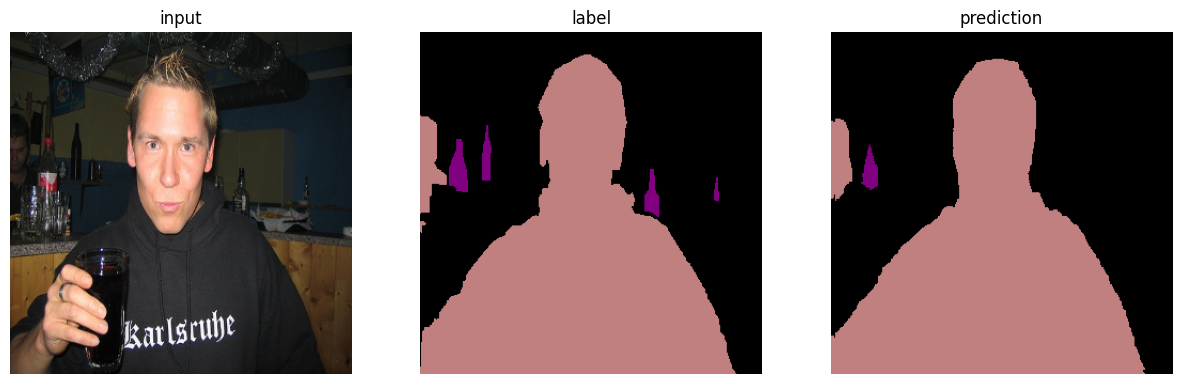

In [43]:
interest_pic = 10

joint_model.eval()
with torch.no_grad():
    target_img, target_label = test_dataset[interest_pic]

    output = joint_model(target_img.unsqueeze(0).to(DEVICE))
    output = output.squeeze(0).permute(1, 2, 0).argmax(dim=2).detach().cpu()

plot_grids(
    [
        img_tensor_to_np(target_img),
        decode_segmap(target_label.numpy(), LABEL_COLORS),
        decode_segmap(output.numpy(), LABEL_COLORS),
    ],
    ["input", "label", "prediction"],
    1,
    3,
    figsize=(15, 15),
)

### for any image

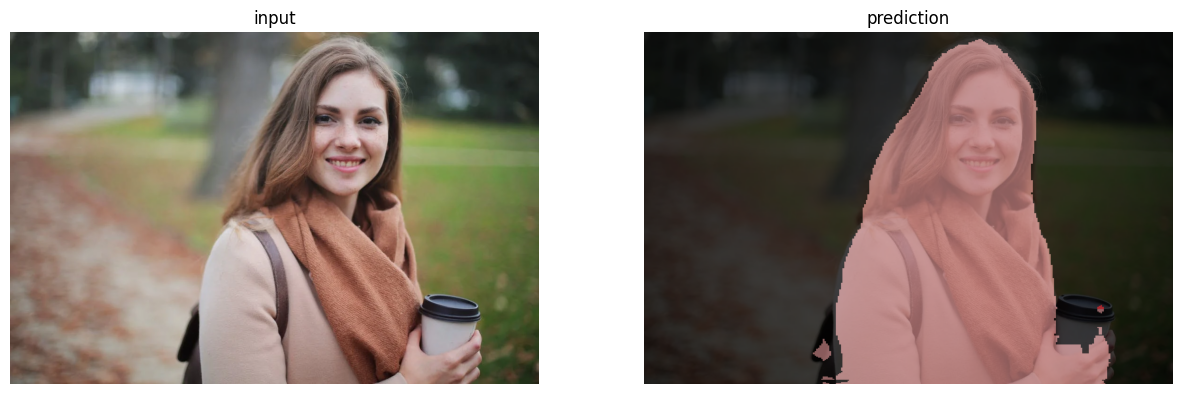

In [44]:
joint_model.eval()
with torch.no_grad():
    target_img = load_image(data_path.joinpath("person.webp"), is_numpy=True)

    h, w, c = target_img.shape
    test_img = test_preprocess(image=target_img)["image"]
    output = joint_model(test_img.unsqueeze(0).to(DEVICE))
    output = output.argmax(dim=1, keepdim=True)
    # B, C, H, W
    output = F.interpolate(output.float(), size=(h, w), mode="nearest")
    # 1, 1, h, w
    output = output.squeeze(0, 1).detach().cpu().numpy()

    coef = 0.7
    mask = decode_segmap(output, LABEL_COLORS)
    overlay_image = target_img.copy()
    for channel_idx in range(c):
        overlay_image[: , : ,channel_idx] = overlay_image[: , : ,channel_idx] * (1 - coef) + mask[: , : ,channel_idx] * coef


    plot_grids(
        [
            target_img,
            overlay_image,
        ],
        ["input", "prediction"],
        1,
        2,
        figsize=(15, 15),
    )